In [1]:
import os
import scanpy as sc
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import SpatialDE
import NaiveDE
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import sys
sys.path.append('../../')

from downstream.svg import detect_svg
from downstream.plotting import *

import utils

# Config

In [12]:
# set global rc parameters
# sc.settings.set_figure_params(vector_friendly=True)

utils.config_rc(dpi=300, font_size=6)
# mpl.rcParams
wk_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))


In [4]:
# raw DLPFC 151673 data result root path
data_root = utils.get_path('svg_wk_root', json_path=os.path.join(wk_root, '_data.json'))
adata = sc.read_h5ad(os.path.join(data_root, "DLPFC_151673/151673.h5ad"))
adata.var_names = [x.upper() for x in adata.var_names.tolist()]
adata.var_names_make_unique()

/hwfssz1/ST_HEALTH/P20Z10200N0170/luoqiuhong/miniconda/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
SpaSEG_SVGs_df = pd.read_csv(os.path.join(data_root,
                                          'DLPFC_151673/svg_151673_All_Domain_except5_Filtered_0.75_8.csv'))
SpaGCN_SVGs_df = pd.read_csv('comp_algos/151673_SVG_3nbr_SpaGCN.csv')
SpatailDE_SVGs_df = pd.read_csv('comp_algos/151673_SpatialDE_SVGs.csv')
SPARK_SVGs_df = pd.read_csv('comp_algos/SPARK_SVGs_pvalue_genename.csv')

In [6]:
SPARK_SVGs_df

,Unnamed: 0,combined_pvalue,adjusted_pvalue,genes
2,28,5.550000e-17,3.005356e-15,ISG15
7,47,2.557692e-03,4.919724e-02,ACAP3
14,58,3.133395e-04,6.740517e-03,ANKRD65
15,62,5.550000e-17,3.005356e-15,VWA1
18,69,7.135546e-05,1.650969e-03,FNDC10
...,...,...,...,...
6536,33506,5.550000e-17,3.005356e-15,MT-ND4
6537,33507,5.550000e-17,3.005356e-15,MT-ND5
6538,33508,4.798748e-06,1.233820e-04,MT-ND6
6539,33509,5.550000e-17,3.005356e-15,MT-CYB


In [7]:
SpaSeg_svg = [x.upper() for x in np.unique(SpaSEG_SVGs_df['gene'].values).tolist()]
SpaGCN_svg = [x.upper() for x in np.unique(SpaGCN_SVGs_df['genes'].values).tolist()]

SpatialDE_svg = [x.upper() for x in np.unique(SpatailDE_SVGs_df['g'].values).tolist()]
Spark_svg = [x.upper() for x in np.unique(SPARK_SVGs_df['genes'].values).tolist()]

In [8]:
# https://github.com/tctianchi/pyvenn

labels = get_labels([
    SpaSeg_svg,
    SpaGCN_svg,
    SpatialDE_svg,
    Spark_svg,
        ], fill=['number'])


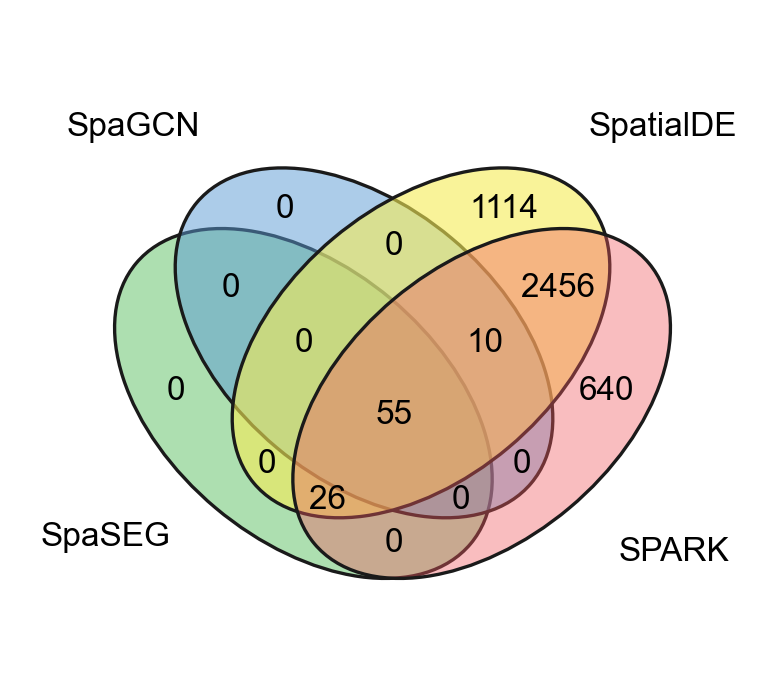

In [9]:
axes_w_cm = 5
w = axes_w_cm * utils.centimeter
fig, ax = venn4(labels, names=['SpaSEG', 'SpaGCN', 'SpatialDE', 'SPARK'],figsize=(w,w),dpi=400, fontsize=6,ec='k',lw=0.6)
ax.get_legend().remove()
plt.savefig(os.path.join(wk_root,'notebook/results/SVG/svg_151673_Venn.pdf'), bbox_inches='tight', format='pdf', dpi=400)

# Moran

## Calculate Moran

In [10]:
# https://squidpy.readthedocs.io/en/stable/auto_examples/graph/compute_moran.html
import squidpy as sq
sq.gr.spatial_neighbors(adata,n_rings=2, coord_type="grid", n_neighs=10)
adata_spaseg = sq.gr.spatial_autocorr(adata,mode="moran",genes=SpaSeg_svg,n_perms=1000,n_jobs=2,copy=True)
adata_spagcn = sq.gr.spatial_autocorr(adata,mode="moran",genes=SpaGCN_svg,n_perms=1000,n_jobs=2,copy=True)
adata_spatailde = sq.gr.spatial_autocorr(adata,mode="moran",genes=SpatialDE_svg,n_perms=1000,n_jobs=2,copy=True)
adata_spark = sq.gr.spatial_autocorr(adata,mode="moran",genes=Spark_svg,n_perms=1000,n_jobs=2,copy=True)
adata_spaseg['algo']='SpaSEG'
adata_spagcn['algo']='SpaGCN'
adata_spatailde['algo']='SpatialDE'
adata_spark['algo']='SPARK'
merge_Moran = pd.concat([adata_spaseg, adata_spagcn,adata_spatailde,adata_spark])
merge_Moran.reset_index(inplace=True,names=['genes'])
merge_Moran.to_csv(os.path.join(wk_root,'notebook/results/SVG/svg_151673_svg_moran_0.75.csv'), index=False)

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

## Plot

In [4]:
merge_Moran=pd.read_csv(os.path.join(wk_root,'notebook/results/SVG/svg_151673_svg_moran_0.75.csv'))

In [5]:
merge_Moran

,genes,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh,algo
0,MBP,0.882059,0.000000,0.000034,0.000000,0.000999,0.000237,0.000000,0.000000,0.000999,SpaSEG
1,GFAP,0.741189,0.000000,0.000034,0.000000,0.000999,0.000202,0.000000,0.000000,0.000999,SpaSEG
2,PLP1,0.707383,0.000000,0.000034,0.000000,0.000999,0.000198,0.000000,0.000000,0.000999,SpaSEG
3,MOBP,0.666932,0.000000,0.000034,0.000000,0.000999,0.000195,0.000000,0.000000,0.000999,SpaSEG
4,CRYAB,0.659030,0.000000,0.000034,0.000000,0.000999,0.000191,0.000000,0.000000,0.000999,SpaSEG
...,...,...,...,...,...,...,...,...,...,...,...
6989,CPNE3,0.002040,0.344893,0.000034,0.300333,0.300699,0.000018,0.345327,0.300710,0.301172,SPARK
6990,DLC1,0.000421,0.452231,0.000034,0.460015,0.449550,0.000018,0.452373,0.460159,0.449692,SPARK
6991,MINDY2,0.000149,0.470863,0.000034,0.473602,0.463536,0.000017,0.470863,0.473602,0.463536,SPARK
6992,VAT1,-0.001673,0.404750,0.000034,0.372039,0.379620,0.000018,0.405004,0.372272,0.379859,SPARK


In [6]:
merge_Moran[['I','algo']].groupby('algo').agg(['min','max','mean','median','std'])

I                                        
                min       max      mean    median       std
algo                                                       
SPARK     -0.001794  0.882059  0.117865  0.083208  0.108465
SpaGCN     0.179118  0.882059  0.415171  0.393384  0.132928
SpaSEG     0.120817  0.882059  0.381426  0.364307  0.140084
SpatialDE -0.003789  0.882059  0.107072  0.072671  0.105120

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SpaSEG vs. SpaGCN: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.078e-02 U_stat=2.202e+03
SpaSEG vs. SpatialDE: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.474e-43 U_stat=2.814e+05
SpaSEG vs. SPARK: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.135e-42 U_stat=2.429e+05


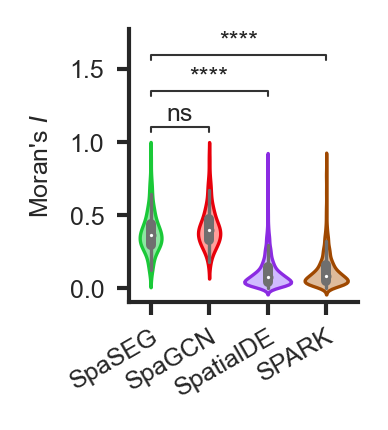

In [14]:
from statannotations.Annotator import Annotator
axes_w_cm = 2.5
axes_h_cm = 3
w = axes_w_cm * utils.centimeter
h = axes_h_cm * utils.centimeter

fig,ax=plt.subplots(figsize=(w,h))

bg_f = ['#8de5a1', '#ff9f9b', '#d0bbff', '#debb9b']
ln_f = ['#1ac938', '#e8000b', '#8b2be2', '#9f4800']

orders = ['SpaSEG','SpaGCN','SpatialDE','SPARK']
palette = dict(zip(orders, bg_f))

plot_param={
        'data':merge_Moran,
        'x':'algo',
        'y':'I',
        'order':orders
    }

axa = sns.violinplot(**plot_param,
                          ax=ax, palette=palette,
                          showfliers=False, 
                          linewidth=0.8,
                          width=0.8,saturation=1)
j = 0
for i,artist in enumerate(ax.collections): 
    if i%2==0:
        artist.set_edgecolor(ln_f[j])
        j+=1

comp_pairs = [('SpaSEG','SpaGCN'),('SpaSEG','SpatialDE'),('SpaSEG','SPARK')]
annot = Annotator(axa, pairs=comp_pairs, **plot_param,plot="violinplot")
annot.configure(test='Mann-Whitney', comparisons_correction="BH", text_format='star', 
                    line_width=0.5,fontsize=6,loc='inside',line_height=0.03, text_offset=0.5)
annot.apply_and_annotate()

xticklabels = axa.set_xticklabels(ax.get_xticklabels(),rotation=30, ha='right',rotation_mode="anchor")
for i, xticklabel in enumerate(xticklabels):
    xticklabel.set_y(xticklabel.get_position()[1] +  0.01)
ax.tick_params(direction='out', length=3, pad=3, width=1)
    
sns.despine()
ax.set_xlabel(None)
ax.set_ylabel("Moran's $\it I$")
# ax.set_title("Moran's $\it I$")
plt.savefig(os.path.join(wk_root,'notebook/results/SVG/svg_151673_moran.pdf'),
            bbox_inches='tight', format='pdf', dpi=400)

# Geary

https://squidpy.readthedocs.io/en/stable/auto_examples/graph/compute_moran.html

## Calculate

In [15]:
sq.gr.spatial_neighbors(adata,n_rings=2, coord_type="grid", n_neighs=10)

In [16]:
adata_spaseg = sq.gr.spatial_autocorr(adata,mode="geary",genes=SpaSeg_svg,n_perms=1000,n_jobs=5,copy=True)
adata_spagcn = sq.gr.spatial_autocorr(adata,mode="geary",genes=SpaGCN_svg,n_perms=1000,n_jobs=5,copy=True)
adata_spatailde = sq.gr.spatial_autocorr(adata,mode="geary",genes=SpatialDE_svg,n_perms=1000,n_jobs=5,copy=True)
adata_spark = sq.gr.spatial_autocorr(adata,mode="geary",genes=Spark_svg,n_perms=1000,n_jobs=5,copy=True)

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

In [17]:
adata_spaseg['algo']='SpaSEG'
adata_spagcn['algo']='SpaGCN'
adata_spatailde['algo']='SpatialDE'
adata_spark['algo']='SPARK'

In [18]:
adata_spaseg

,C,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh,algo
MBP,0.123018,0.000000e+00,0.000034,0.000000e+00,0.000999,0.000234,0.000000e+00,0.000000e+00,0.000999,SpaSEG
GFAP,0.261203,0.000000e+00,0.000034,0.000000e+00,0.000999,0.000203,0.000000e+00,0.000000e+00,0.000999,SpaSEG
PLP1,0.294598,0.000000e+00,0.000034,0.000000e+00,0.000999,0.000186,0.000000e+00,0.000000e+00,0.000999,SpaSEG
MOBP,0.335966,0.000000e+00,0.000034,0.000000e+00,0.000999,0.000170,0.000000e+00,0.000000e+00,0.000999,SpaSEG
CRYAB,0.345338,0.000000e+00,0.000034,0.000000e+00,0.000999,0.000181,0.000000e+00,0.000000e+00,0.000999,SpaSEG
...,...,...,...,...,...,...,...,...,...,...
H3F3B,0.836159,6.819528e-176,0.000034,3.999240e-102,0.000999,0.000059,7.173790e-176,4.153057e-102,0.000999,SpaSEG
H3F3A,0.844992,1.100308e-157,0.000034,7.913008e-93,0.000999,0.000060,1.142628e-157,8.113338e-93,0.000999,SpaSEG
BIN1,0.846665,2.387815e-154,0.000034,2.280248e-103,0.000999,0.000051,2.448266e-154,2.398702e-103,0.000999,SpaSEG
HTRA1,0.867505,7.932032e-116,0.000034,2.700122e-84,0.000999,0.000049,8.031183e-116,2.733874e-84,0.000999,SpaSEG


In [19]:
merge_geary = pd.concat([adata_spaseg, adata_spagcn,adata_spatailde,adata_spark])
merge_geary.reset_index(inplace=True,names=['genes'])
merge_geary.to_csv(os.path.join(wk_root,'notebook/results/SVG/svg_151673_svg_geary_0.75.csv'), index=False)

## Plot

In [7]:
merge_geary=pd.read_csv(os.path.join(wk_root,'notebook/results/SVG/svg_151673_svg_geary_0.75.csv'))

In [9]:
merge_geary['adj_C'] = 1- merge_geary['C']

In [10]:
merge_geary[['adj_C','algo']].groupby('algo').agg(['min','max','mean','median','std'])

adj_C                                        
                min       max      mean    median       std
algo                                                       
SPARK     -0.004290  0.876982  0.115862  0.081364  0.108356
SpaGCN     0.176208  0.876982  0.412663  0.388447  0.132477
SpaSEG     0.118959  0.876982  0.379013  0.358067  0.139801
SpatialDE -0.011068  0.876982  0.105210  0.070891  0.104960

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SpaSEG vs. SpaGCN: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.929e-02 U_stat=2.200e+03
SpaSEG vs. SpatialDE: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.470e-43 U_stat=2.814e+05
SpaSEG vs. SPARK: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.145e-42 U_stat=2.429e+05


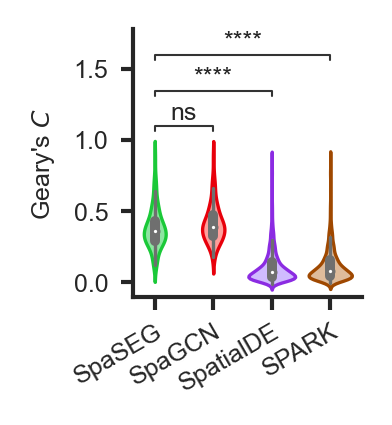

In [13]:
from statannotations.Annotator import Annotator
axes_w_cm = 2.5
axes_h_cm = 3
w = axes_w_cm * utils.centimeter
h = axes_h_cm * utils.centimeter

fig,ax=plt.subplots(figsize=(w,h))

bg_f = ['#8de5a1', '#ff9f9b', '#d0bbff', '#debb9b']
ln_f = ['#1ac938', '#e8000b', '#8b2be2', '#9f4800']

orders = ['SpaSEG','SpaGCN','SpatialDE','SPARK']
palette = dict(zip(orders, bg_f))

plot_param={
        'data':merge_geary,
        'x':'algo',
        'y':'adj_C',
        'order':orders
    }

axa = sns.violinplot(**plot_param,
                          ax=ax, palette=palette,
                          showfliers=False, 
                          linewidth=0.8,
                          width=0.8,saturation=1, inner ='box')
j = 0
for i,artist in enumerate(ax.collections): 
    if i%2==0:
        artist.set_edgecolor(ln_f[j])
        j+=1

comp_pairs = [('SpaSEG','SpaGCN'),('SpaSEG','SpatialDE'),('SpaSEG','SPARK')]
annot = Annotator(axa, pairs=comp_pairs, **plot_param,plot="violinplot")
annot.configure(test='Mann-Whitney', comparisons_correction="BH", text_format='star', 
                    line_width=0.5,fontsize=6,loc='inside',line_height=0.03, text_offset=0.5)
annot.apply_and_annotate()

xticklabels = axa.set_xticklabels(ax.get_xticklabels(),rotation=30, ha='right',rotation_mode="anchor")
for i, xticklabel in enumerate(xticklabels):
    xticklabel.set_y(xticklabel.get_position()[1] +  0.01)
ax.tick_params(direction='out', length=3, pad=3, width=1)

sns.despine()
ax.set_xlabel(None)
ax.set_ylabel(r"Geary's $\it C$")
# ax.set_title(r"Geary's $\it C$")
plt.savefig(os.path.join(wk_root,'notebook/results/SVG/svg_151673_geary.pdf'),
            bbox_inches='tight', format='pdf', dpi=400)


# Running Time

In [38]:
run_time = {'SpaSEG': 0.83, 'SpaGCN': 1.37, 'SpatialDE':44.41, 'SPARK': 404.67}

algos = list(run_time.keys())
time_minutes = list(run_time.values())

time_df = pd.DataFrame(data={'algo':algos, 'time':time_minutes})

In [39]:
time_df

,algo,time
0,SpaSEG,0.83
1,SpaGCN,1.37
2,SpatialDE,44.41
3,SPARK,404.67


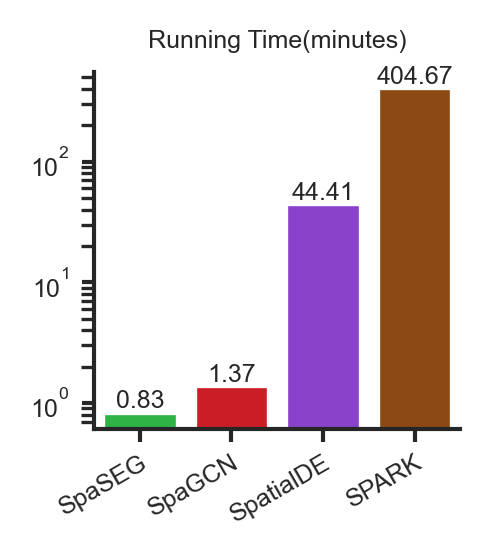

In [42]:
bg_f = ['#8de5a1', '#ff9f9b', '#d0bbff', '#debb9b']
ln_f = ['#1ac938', '#e8000b', '#8b2be2', '#9f4800']

orders = ['SpaSEG','SpaGCN','SpatialDE','SPARK']
palette = dict(zip(orders, ln_f))

axes_w_cm = 4
axes_h_cm = 4
w = axes_w_cm * utils.centimeter
h = axes_h_cm * utils.centimeter

fig = plt.figure(figsize = (w, h))
plt.yscale("log")
# creating the bar plot
ax = sns.barplot(data=time_df, x='algo',y='time', palette=palette, order=orders)
plt.xlabel(None)
plt.ylabel(None)
xticklabels = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha='right',rotation_mode="anchor")
for i, xticklabel in enumerate(xticklabels):
    xticklabel.set_y(xticklabel.get_position()[1] +  0.01)
ax.tick_params(direction='out', length=3, pad=3, width=1)
sns.despine()
for i in ax.containers:
    ax.bar_label(i,)
    
ax.set_title("Running Time(minutes)")
plt.savefig(os.path.join(wk_root,'notebook/results/SVG/svg_151673_runningtime.pdf'),
            bbox_inches='tight', format='pdf', dpi=400)